In [44]:
%matplotlib inline
import os
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bz2
import montage_wrapper as mw

In [2]:
def sample(n=50000):
    """
    """
    url = "http://skyserver.sdss.org/dr12/en/tools/search/x_sql.aspx"
    payload = {
        "format": "json",
        "cmd": """
            SELECT TOP {0} spec.specObjID,
                phot.objID,
                spec.ra,
                spec.dec,
                spec.class,
                spec.z,
                spec.zErr,
                phot.rerun,
                phot.run,
                phot.camcol,
                phot.field,
                phot.dered_u,
                phot.dered_g,
                phot.dered_r,
                phot.dered_i,
                phot.dered_z
            FROM SpecObjAll AS spec
            JOIN PhotoObjAll AS phot
            ON spec.specObjID = phot.specObjID
            WHERE
                phot.clean = 1
                AND spec.zWarning = 0
            ORDER BY NEWID()
        """.format(n).strip()
    }

    resp = requests.post(url, params=payload)
    
    data = resp.json()[0]['Rows']
    
    df = pd.DataFrame(data)

    return df

In [3]:
s = sample(n=10)
s.to_csv("objects.csv")

df = pd.read_csv("objects.csv")

Images and derived catalog data are described on the imaging data page. You can use a SkyServer search or the file window_flist.fits file to identify which RERUN-RUN-CAMCOL-FIELD overlaps your region of interest. Then download the matching calibObj files (catalog data) or frame files (calibrated imaging data), e.g., for RERUN 301, RUN 2505, CAMCOL 3, FIELD 38, the r-band image is:

```shell
$ wget --spider http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/2505/3/frame-r-002505-3-0038.fits.bz2
```

In [15]:
def fetch_fits(df):

    bands = [c for c in 'ugriz']
    
    run = df[["rerun", "run", "camcol", "field"]].drop_duplicates()
    
    if not os.path.exists("images/raw"):
        os.makedirs("images/raw")

    for row in run.iterrows():
        r = row[1]
        
        for band in bands:
            url = "http://data.sdss3.org/sas/dr12/boss/photoObj/frames/{0}/{1}/{2}/".format(
                r.rerun, r.run, r.camcol, r.field, band)
            filename = "frame-{4}-{1:06d}-{2}-{3:04d}.fits.bz2".format(
                r.rerun, r.run, r.camcol, r.field, band)
            filepath = os.path.join("images/raw", filename)
            
            if os.path.exists(filepath.replace(".bz2", "")):
                print("Skipping {}".format(filename))
            else:
                print("Downloading and extracting {}".format(filename))
                
                resp = requests.get(url + filename, stream=True)
            
                with open(filepath.replace(".bz2", ""), "wb") as f:
                    img = bz2.decompress(resp.content)
                    f.write(img)

In [16]:
fetch_fits(df)

In [61]:
ref_images = [f for f in os.listdir("images/raw") if "frame-r-" in f]
# uncomment for production
ref_images = ref_images[:1]
print(ref_images)

['frame-r-001458-2-0372.fits']


In [90]:
if not os.path.exists("images/header"):
    os.makedirs("images/header")

if not os.path.exists("images/registered"):
    os.makedirs("images/registered")

for image in ref_images:
    
    header = os.path.join("images/header", image.replace("frame", "header").replace(".fits", ".hdr"))

    mw.commands.mGetHdr(os.path.join("images/raw", image), header)

    in_images = [os.path.join("images/raw", image.replace("frame-r-", "frame-{}-").format(b)) for b in "ugriz"]
    out_images = [os.path.join("images/registered", image.replace("frame-r-", "registered-{}-").format(b)) for b in "ugriz"]

    mw.reproject(in_images, out_images, silent_cleanup=True, common=True)
                 #north_aligned=True, system='EQUJ', exact_size=True, common=True, silent_cleanup=True)

In [91]:
from astropy.io import fits

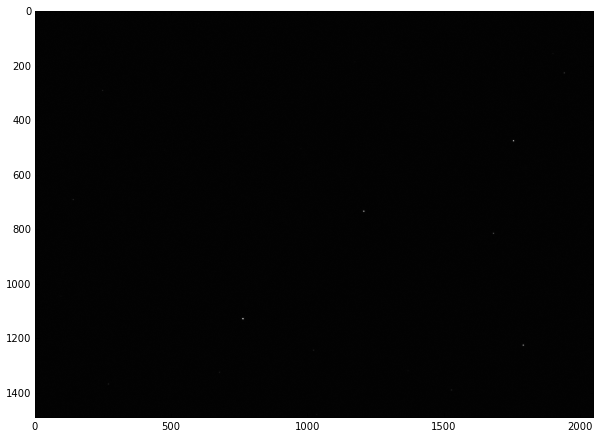

In [92]:
image_data = fits.getdata("images/raw/frame-u-001458-2-0372.fits")

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_data, cmap="gray")